# Missing values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(430)

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

We laden hier de heart-disease dataset in, maar we verwijderen allerlei random waarden in de test dataset.
Wij gaan proberen om die waarden zo goed mogelijk in te vullen en een zo hoog mogelijke score te krijgen

In [2]:
df = pd.read_csv("dataset/heart.csv")
df = df.drop(columns=['exang','oldpeak','slope', 'fbs','age','thal','ca'])
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=100, random_state=99)

In [3]:
for index, row in X_test.iterrows():
    for x in range(3):
        col_to_clear = random.choice((X_test).columns)
        X_test[col_to_clear][index] = np.nan

In [4]:
print("Train dataset size:",X_train.shape[0])
print("Test dataset size", X_test.shape[0])

Train dataset size: 203
Test dataset size 100


Met deze functie kun je de accuracy van je invulling van missende waarden

In [5]:
clf = RandomForestClassifier(random_state=300, max_leaf_nodes=2, n_estimators=10)
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=2, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=300,
                       verbose=0, warm_start=False)

In [6]:
def test_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_pred, y_test)

Je ziet hieronder dat er aardig wat waarden missen

In [7]:
X_test.head(10)

,sex,cp,trestbps,chol,restecg,thalach
137,1.0,NaN,NaN,208.0,0.0,NaN
262,NaN,NaN,123.0,282.0,1.0,95.0
43,0.0,0.0,NaN,NaN,0.0,143.0
90,NaN,NaN,124.0,255.0,1.0,175.0
32,1.0,1.0,130.0,NaN,NaN,188.0
61,NaN,NaN,108.0,309.0,1.0,156.0
72,1.0,NaN,NaN,204.0,0.0,NaN
10,1.0,NaN,NaN,NaN,1.0,160.0
240,1.0,NaN,NaN,269.0,1.0,112.0
111,1.0,NaN,150.0,126.0,NaN,NaN


Als we alle NaN waarden naar 0 zetten krijgen we een score van 0.66

In [8]:
# All nan values to 0
test_model(clf, X_train, X_test.replace(np.nan,0), y_train, y_test)

0.56

In [9]:
# All nan values to most common of that target
change_list = []
train_temp = X_train.join(y_train)
test_temp = X_test.join(y_test)
for index, row in test_temp.iterrows():
    row_set = False
    for col, value in row.iteritems():
        if np.isnan(value):
            try:
                if col in ['age','trestbps','chol','thalach']:
                    m = train_temp[train_temp.target == row.target][col].mean()
                else:
                    m = train_temp[train_temp.target == row.target][col].mode()
                X_test[col][index] = m
            except:
                X_test[col][index] = 0
                print("Error:",col)
            
            if row_set == False:
                change_list.append((col,index))
                row_set = True
X_test.head(10)

,sex,cp,trestbps,chol,restecg,thalach
137,1.0,2.0,129.058824,208.000000,0.0,157.205882
262,1.0,0.0,123.000000,282.000000,1.0,95.000000
43,0.0,0.0,129.058824,241.431373,0.0,143.000000
90,1.0,2.0,124.000000,255.000000,1.0,175.000000
32,1.0,1.0,130.000000,241.431373,1.0,188.000000
61,1.0,2.0,108.000000,309.000000,1.0,156.000000
72,1.0,2.0,129.058824,204.000000,0.0,157.205882
10,1.0,2.0,129.058824,241.431373,1.0,160.000000
240,1.0,0.0,135.178218,269.000000,1.0,112.000000
111,1.0,2.0,150.000000,126.000000,1.0,157.205882


In [10]:
# All nan values to 0
test_model(clf, X_train, X_test, y_train, y_test)

0.87

# Proximity matrix

In [11]:
# clf = RandomForestClassifier(random_state=300, max_features=2, min_samples_leaf=20, n_estimators=3)
clf.fit(X_train,y_train)
leaves = clf.apply(X_train)
leaves.shape

(203, 10)

In [12]:
# leaves

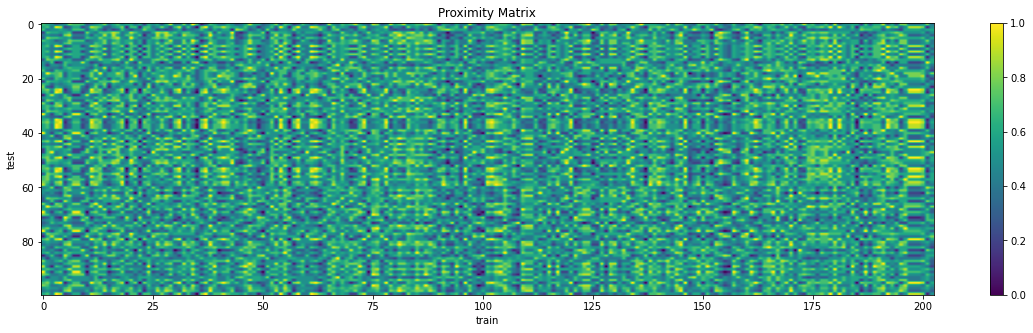

In [13]:
# proximity_matrix = np.zeros([X_train.count()[0]+1, X_train.count()[0]+1])
# print(proximity_matrix)
proximity_matrix = np.zeros([X_train.count()[0], len(change_list)])
n_trees = leaves.shape[1]

for item_index, item in enumerate(change_list):
    apl = clf.apply([X_test.loc[item[1]]])
    
    for tree_number in range(n_trees):
        for index, leaf in enumerate(leaves.T[tree_number]):
            if leaf == apl[0][tree_number]:
                proximity_matrix[index, item_index] += 1
                
plt.figure(figsize=[20,5])
plt.title("Proximity Matrix")
plt.xlabel('train')
plt.ylabel("test")
proximity_matrix = proximity_matrix/n_trees
plt.imshow(proximity_matrix.T, aspect='auto')
plt.colorbar()

In [24]:
X_test_proximity = X_test.copy()

for item_index, item in enumerate(change_list):
    cur_val = X_test_proximity[item[0]][item[1]]
    total = cur_val
    for i,x in enumerate(proximity_matrix[item_index]):
        total += (x * X_train[item[0]].iloc[i])
        
    new_val = total / X_train.shape[0]
    if item[0] in ['sex','cp','fbs', 'restecg']:
        new_val = round(new_val)
    print(cur_val,'->',new_val)
    
    X_test_proximity[item[0]][item[1]] = new_val   
test_model(clf, X_train, X_test_proximity, y_train, y_test)

2.0 -> 0.0
1.0 -> 0.0
129.05882352941177 -> 32.31161982034194
1.0 -> 0.0
241.4313725490196 -> 72.23660774654692
1.0 -> 0.0
2.0 -> 0.0
2.0 -> 0.0
0.0 -> 0.0
2.0 -> 0.0
0.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
129.05882352941177 -> 40.17368878585918
2.0 -> 0.0
129.05882352941177 -> 27.940191248913365
1.0 -> 0.0
241.4313725490196 -> 78.25680479088184
1.0 -> 0.0
255.5148514851485 -> 55.41829976101058
1.0 -> 0.0
2.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
0.0 -> 0.0
129.05882352941177 -> 40.09782671689366
129.05882352941177 -> 36.15792523906114
255.5148514851485 -> 76.46756084475443
0.0 -> 0.0
1.0 -> 0.0
2.0 -> 0.0
1.0 -> 0.0
0.0 -> 0.0
1.0 -> 0.0
0.0 -> 0.0
0.0 -> 0.0
0.0 -> 0.0
0.0 -> 0.0
2.0 -> 0.0
0.0 -> 0.0
241.4313725490196 -> 72.23660774654692
1.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
129.05882352941177 -> 30.16679223413503
2.0 -> 0.0
2.0 -> 0.0
2.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
2.0 -> 0.0
1.0 -> 0.0
0.0 -> 0.0
1.0 -> 0.0
1.0 -> 0.0
255.5148514851485 -> 55.41829976101058
1.0 -> 0.0
1.0 -> 0.0
0.0 -> 0

0.73

In [15]:
test_model(clf, X_train, X_test_proximity, y_train, y_test)

0.85